In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
attr_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/CC/peaks_vs_notpeaks/resnet/attributions.npy"
gen_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/CC/peaks_vs_notpeaks/resnet/locations.npy"
score_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/CC/peaks_vs_notpeaks/resnet/resnet.csv.gz"

In [36]:
attr_arr = np.load(attr_file)
gen_arr = np.load(gen_file)
gen_df = pd.DataFrame(gen_arr, columns=["chrm", "start", "end"])
gen_df.start = gen_df.start.astype("int64")
gen_df.end = gen_df.end.astype("int64")
score_df = pd.read_csv(score_file, header=None, names=["ypred", "ytarget", "chrm", "start", "end"])

In [37]:
assert score_df.loc[:, ["chrm", "start", "end"]].equals(gen_df)

In [38]:
score_df = score_df.sort_values("ypred")

In [39]:
score_df

,ypred,ytarget,chrm,start,end
14644,7.975848e-26,0,chr5,82165187,82165687
1462,2.548837e-25,0,chr12,1571925,1572425
3914,4.812236e-25,0,chr14,56130994,56131494
22313,6.646556e-25,0,chr3,57015446,57015946
1496,1.472776e-24,0,chr7,69645833,69646333
...,...,...,...,...,...
140,1.000000e+00,1,chrX,12956121,12956621
148,1.000000e+00,1,chr2,55099999,55100499
169,1.000000e+00,1,chr4,156771318,156771818
195,1.000000e+00,1,chr14,70011086,70011586


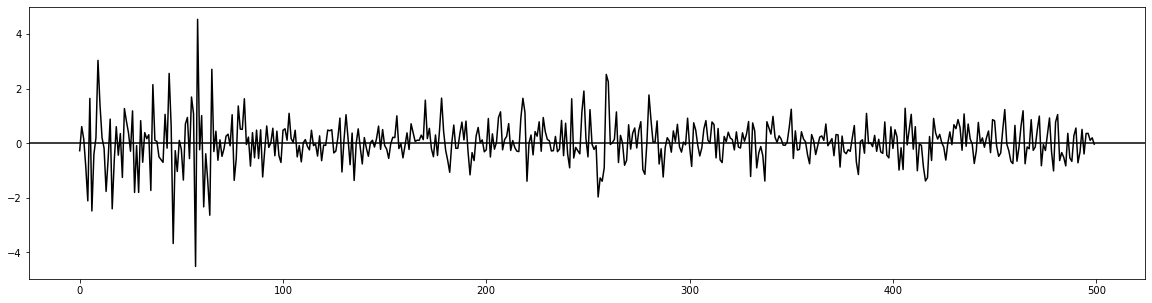

In [41]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(x=range(500), y=attr_arr[14644], ax=ax, color="k")
ax.axhline(0, color="k", xmin=0, xmax=500)